# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [46]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-08 15:37 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-08 15:37 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-08 15:37 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-08 15:37 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-08 15:37 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-08 15:37 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-08 15:37 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-08 15:37 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-08 15:37 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [47]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [48]:
ratings = sc.textFile(RATINGS_PATH)

In [49]:
%%time
ratings.take(5)

CPU times: user 10.4 ms, sys: 108 µs, total: 10.5 ms
Wall time: 2.03 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [50]:
ratings.getNumPartitions()

5

In [51]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [52]:
ratings.count()

25000095

Количество пользователей

In [53]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 13.9 ms, sys: 10.5 ms, total: 24.4 ms
Wall time: 1min 2s


162541

Сохраним датасет в память

In [54]:
ratings = ratings.persist()

In [55]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24.6 ms, sys: 2.88 ms, total: 27.4 ms
Wall time: 1min 48s


162541

Количество фильмов

In [56]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 18.2 ms, sys: 1.07 ms, total: 19.2 ms
Wall time: 33.8 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [57]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [58]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [59]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [60]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-08 16:05 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58940 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112466 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131424 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114295 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133774 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117742 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142933 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132311 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167599 2021-02-08 16:05 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [61]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [62]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [65]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

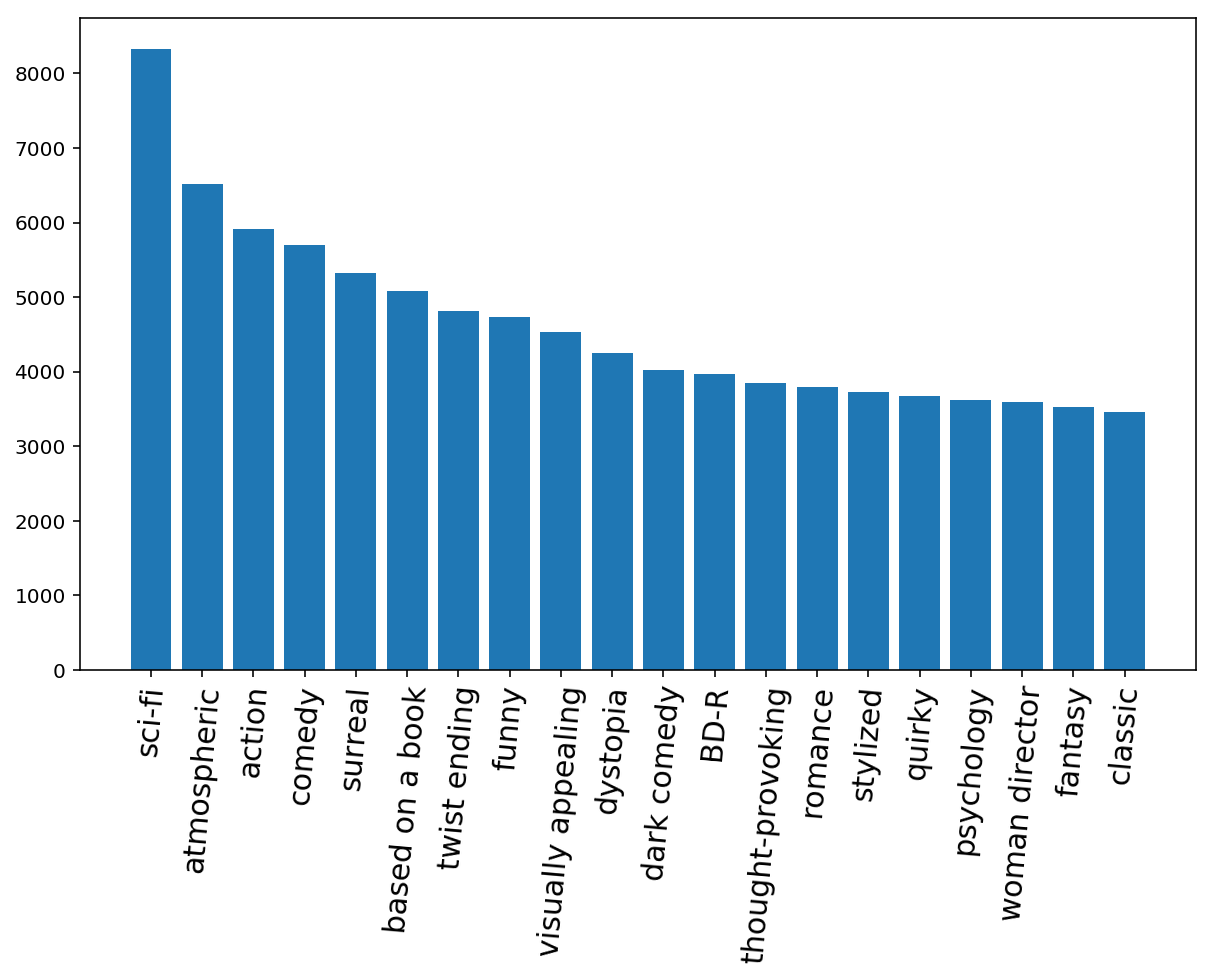

In [66]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [103]:
ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_values: key_values[1], ascending=False) \
    .map(lambda key_values: (key_values[1][1][1], key_values[1][0])) \
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [104]:
ratings \
    .map(lambda r: (r.movie_id,  r.rating)) \
    .filter(lambda key_value: key_value[1] == 5) \
    .mapValues(lambda value: 1) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_values: key_values[1], ascending=False) \
    .map(lambda key_values: (key_values[1][1][1], key_values[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [135]:
avg_ratings = movie_avg_rating \
    .map(lambda key_value: key_value[1]) \
    .collect()

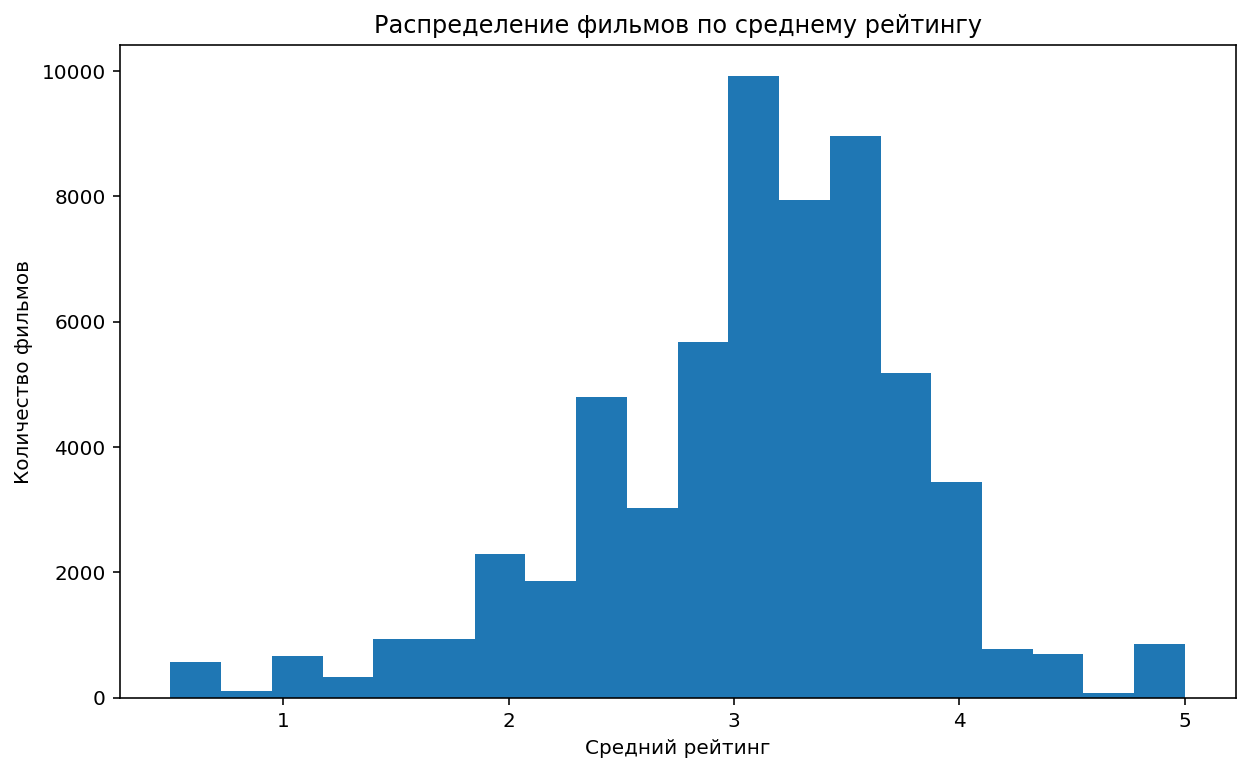

In [136]:
plt.figure(figsize=(10, 6))
plt.title('Распределение фильмов по среднему рейтингу')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество фильмов')
plt.hist(avg_ratings, bins=20);

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [131]:
ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda key_value: key_value[1]) \
    .collect()

In [143]:
min(ratings_count), max(ratings_count)

(1, 81491)

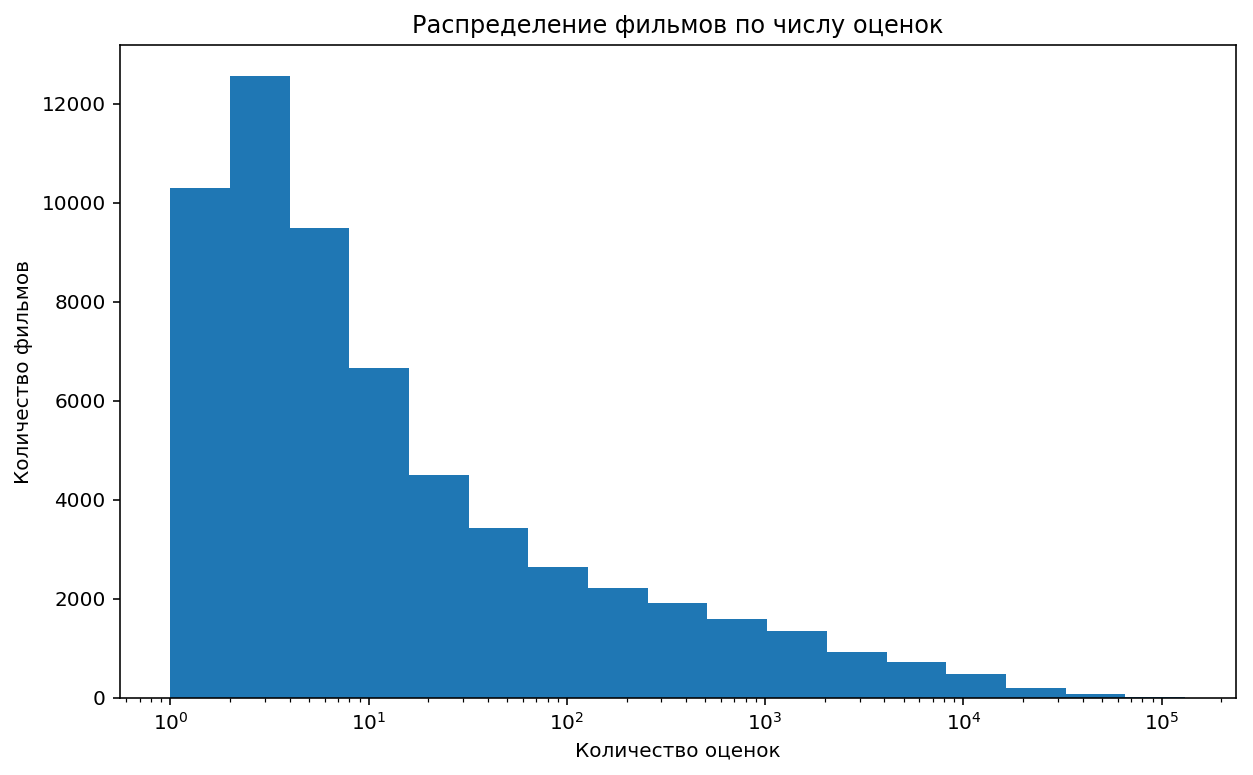

In [154]:
bins = [2 ** i for i in range(0, 18)]
plt.figure(figsize=(10, 6))
plt.title('Распределение фильмов по числу оценок')
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')
plt.xscale('log')
plt.hist(ratings_count, bins=bins);

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [ ]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################